In [ ]:
# Imports : google collab version
import numpy as np
import cv2
import matplotlib.pyplot as plt
!pip install rembg
!pip install onnxruntime
from rembg import remove
from PIL import Image
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


Upload an image to proceed


Saving IMG20220818175051-6D49A.jpg to IMG20220818175051-6D49A.jpg


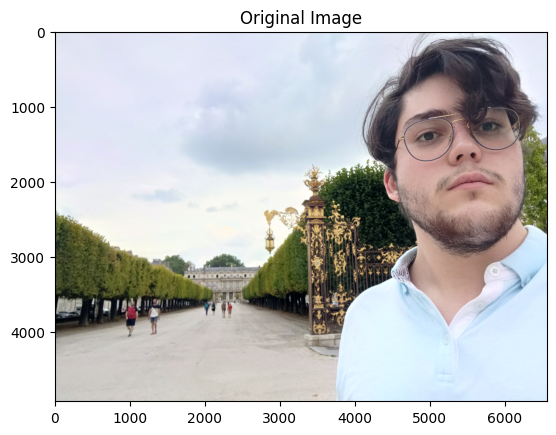

In [ ]:
#Image upload

print("Upload an image to proceed")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Exiting...")
    exit()

file_path = list(uploaded.keys())[0]
image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Original Image")
plt.show()


In [ ]:
# Person selection by the user
height, width, _ = image.shape
print(f"Image dimensions: width={width}, height={height}")
def select_point_manually():
    print("Enter the x, y coordinates of the person to remove:")
    print(f"Note: x should be between 0 and {width-1}, y should be between 0 and {height-1}")
    click_x = int(input("Enter x-coordinate: "))
    click_y = int(input("Enter y-coordinate: "))
    return click_x, click_y

click_x, click_y = select_point_manually()


Image dimensions: width=6560, height=4928
Enter the x, y coordinates of the person to remove:
Note: x should be between 0 and 6559, y should be between 0 and 4927
Enter x-coordinate: 5500
Enter y-coordinate: 1200


Person detection : Histogram of Oriented Gradients (HOG) with Support Vector Machines (SVM) - Inpainting : Interpolation

Generating mask using HOG + SVM...


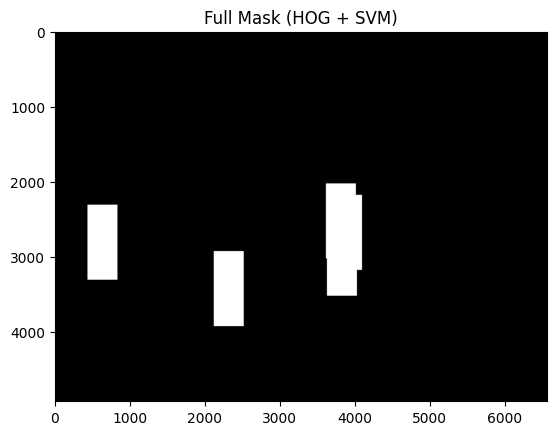

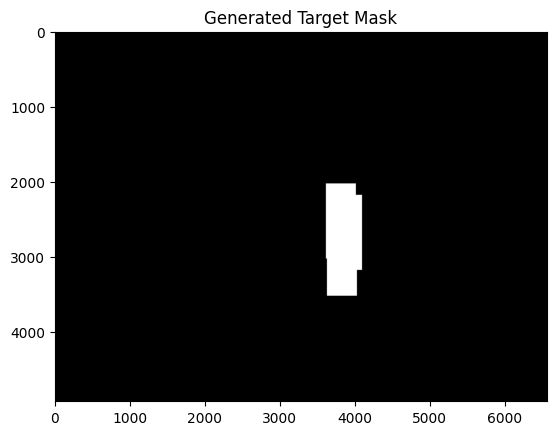

Performing inpainting...


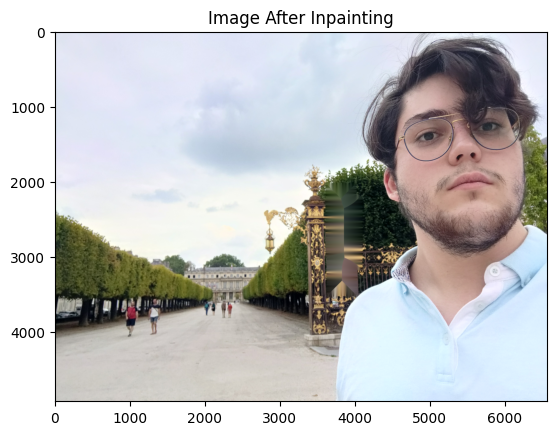

In [ ]:
# Segmentation and mask creation using HOG + SVM
print("Generating mask using HOG + SVM...")

# Initialize HOG descriptor
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Detect people in the image
rects, _ = hog.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1)

# Generate a binary mask
mask_np = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)


for (x, y, w, h) in rects:
    mask_np[y-400:y+600, x-200:x+200] = 255

# Show the full mask
plt.imshow(mask_np, cmap='gray')
plt.title("Full Mask (HOG + SVM)")
plt.show()

# Label connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_np, connectivity=8)

# Find the closest object to the click position
min_dist = float('inf')
closest_label = 0
for label_idx, (cx, cy) in enumerate(centroids):
    if label_idx == 0:  # Skip background
        continue
    dist = np.sqrt((click_x - cx) ** 2 + (click_y - cy) ** 2)
    if dist < min_dist:
        min_dist = dist
        closest_label = label_idx

# Generate a mask for the closest object
target_mask = np.where(labels == closest_label, 255, 0).astype(np.uint8)

plt.imshow(target_mask, cmap='gray')
plt.title("Generated Target Mask")
plt.show()

# Inpainting using interpolation
print("Performing inpainting...")
inpainted_image = cv2.inpaint(
    image, target_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA
)

plt.imshow(inpainted_image)
plt.title("Image After Inpainting")
plt.show()


Generating mask using Edge and Contour-Based Detection for person detection...


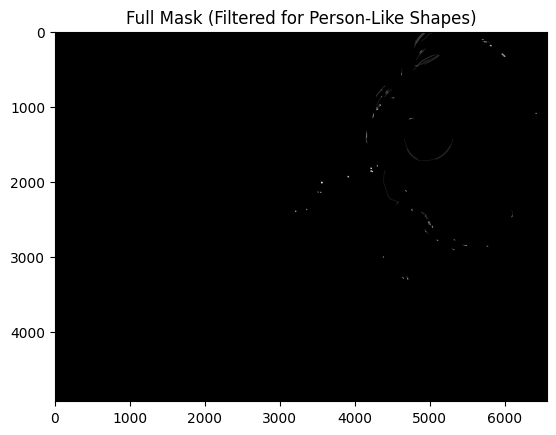

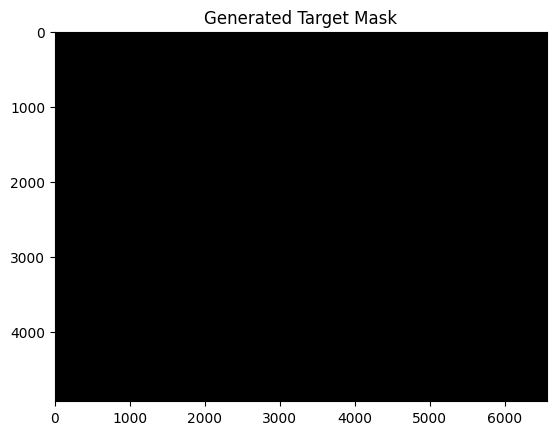

Performing inpainting...


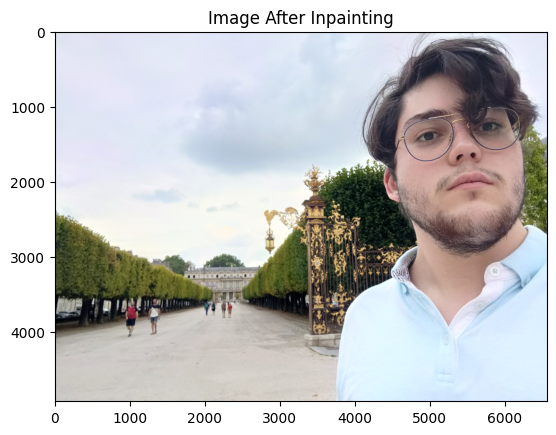

In [ ]:
# Segmentation and mask creation using Edge and Contour-Based Detection for Person Detection
print("Generating mask using Edge and Contour-Based Detection for person detection...")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply edge detection (Canny)
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Find contours from the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Generate a binary mask
mask_np = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Draw the contours onto the mask
cv2.drawContours(mask_np, contours, -1, (255), thickness=cv2.FILLED)

# Filter contours based on aspect ratio and size to approximate person-like shapes
person_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = h / float(w)
    area = cv2.contourArea(contour)
    if area > 100:  # Typical bounds for human-like shapes
        person_contours.append(contour)

# Clear the mask and draw only the filtered person contours
mask_np = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
cv2.drawContours(mask_np, person_contours, -1, (255), thickness=cv2.FILLED)

# Show the full mask
plt.imshow(mask_np, cmap='gray')
plt.title("Full Mask (Filtered for Person-Like Shapes)")
plt.show()

# Label connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_np, connectivity=4)

# Find the closest object to the click position
min_dist = float('inf')
closest_label = 0
for label_idx, (cx, cy) in enumerate(centroids):
    if label_idx == 0:  # Skip background
        continue
    dist = np.sqrt((click_x - cx) ** 2 + (click_y - cy) ** 2)
    if dist < min_dist:
        min_dist = dist
        closest_label = label_idx

# Generate a mask for the closest object
target_mask = np.where(labels == closest_label, 255, 0).astype(np.uint8)

plt.imshow(target_mask, cmap='gray')
plt.title("Generated Target Mask")
plt.show()

# Inpainting using interpolation
print("Performing inpainting...")
inpainted_image = cv2.inpaint(
    image, target_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA
)

plt.imshow(inpainted_image)
plt.title("Image After Inpainting")
plt.show()


Person detection : U2NET  - Inpainting : Interpolation

Generating mask...


100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 82.4GB/s]


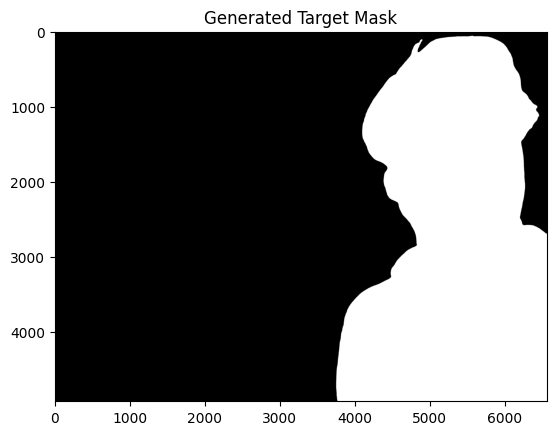

Performing inpainting...


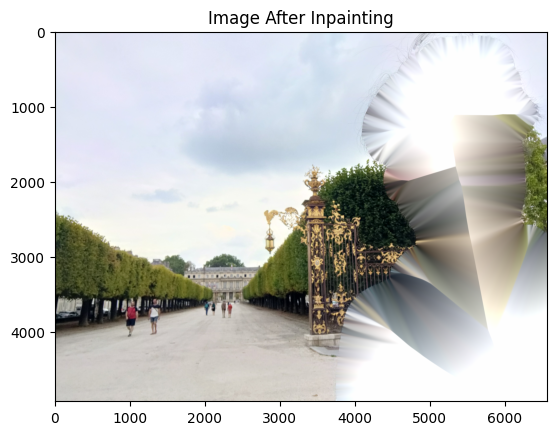

In [ ]:
# Segmentation and mask creation
print("Generating mask...")
image_pil = Image.fromarray(image)
mask = remove(image_pil)
mask_np = np.array(mask)[:, :, -1]  # Extract the alpha channel

# Normalize the mask to ensure values are binary (0 or 255)
mask_np = (mask_np > 128).astype(np.uint8) * 255

# Label connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_np, connectivity=8)

# Find the closest object to the click position
min_dist = float('inf')
closest_label = 0
for label_idx, (cx, cy) in enumerate(centroids):
    if label_idx == 0:  # Skip background
        continue
    dist = np.sqrt((click_x - cx) ** 2 + (click_y - cy) ** 2)
    if dist < min_dist:
        min_dist = dist
        closest_label = label_idx

# Step 3.3: Generate a mask for the closest object
target_mask = np.where(labels == closest_label, 255, 0).astype(np.uint8)

plt.imshow(target_mask, cmap='gray')
plt.title("Generated Target Mask")
plt.show()

# Step 4: Inpainting
print("Performing inpainting...")
inpainted_image = cv2.inpaint(
    image, target_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA
)

plt.imshow(inpainted_image)
plt.title("Image After Inpainting")
plt.show()

Person detection : AI (Mask R-CNN)  - Inpainting : Interpolation

In [ ]:
from google.colab import files
import torch
from torchvision import models, transforms

Detecting persons using Mask R-CNN...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 175MB/s]


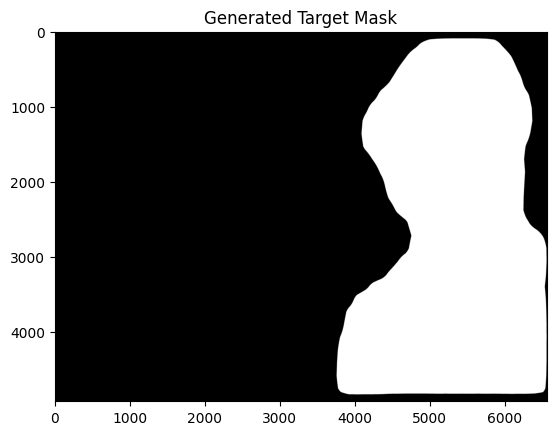

Performing inpainting...


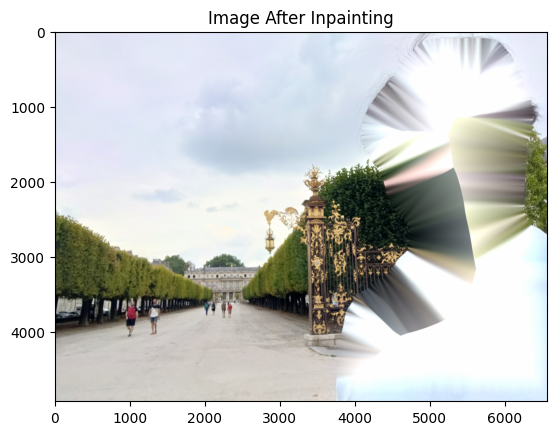

In [ ]:
# Step 3: Detect persons using Mask R-CNN
print("Detecting persons using Mask R-CNN...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Preprocess the image for the model
transform = transforms.Compose([
    transforms.ToTensor()
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    predictions = model(input_image)[0]

# Extract masks and person class detections
person_masks = []
for i in range(len(predictions["labels"])):
    if predictions["labels"][i] == 1 and predictions["scores"][i] > 0.5:  # Class 1 corresponds to 'person'
        person_masks.append((predictions["masks"][i, 0] > 0.5).cpu().numpy().astype(np.uint8))

if not person_masks:
    print("No persons detected. Exiting...")
    exit()

# Step 4: Find the person closest to the click
min_dist = float('inf')
closest_mask = None
for mask in person_masks:
    ys, xs = np.where(mask == 1)
    centroid_x, centroid_y = np.mean(xs), np.mean(ys)
    dist = np.sqrt((click_x - centroid_x) ** 2 + (click_y - centroid_y) ** 2)
    if dist < min_dist:
        min_dist = dist
        closest_mask = mask

# Ensure the closest mask is binary and scaled to 255
target_mask = (closest_mask * 255).astype(np.uint8)
plt.imshow(target_mask, cmap='gray')
plt.title("Generated Target Mask")
plt.show()

# Step 5: Inpainting
print("Performing inpainting...")
inpainted_image = cv2.inpaint(
    image, target_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA
)

plt.imshow(inpainted_image)
plt.title("Image After Inpainting")
plt.show()

Person detection : AI (Mask R-CNN)  - Inpainting : AI (Stable Diffusion)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
pipeline.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Detecting persons using Mask R-CNN...


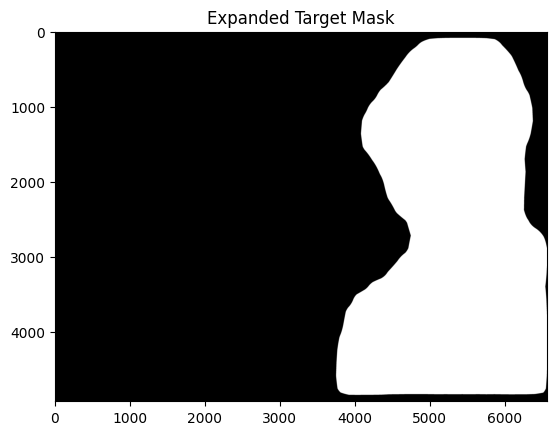

Performing inpainting using Stable Diffusion...


  0%|          | 0/50 [00:00<?, ?it/s]

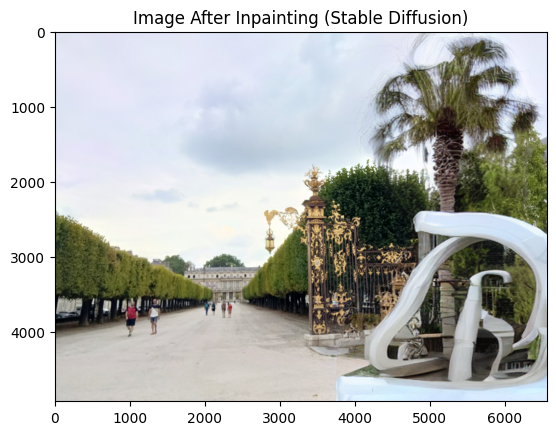

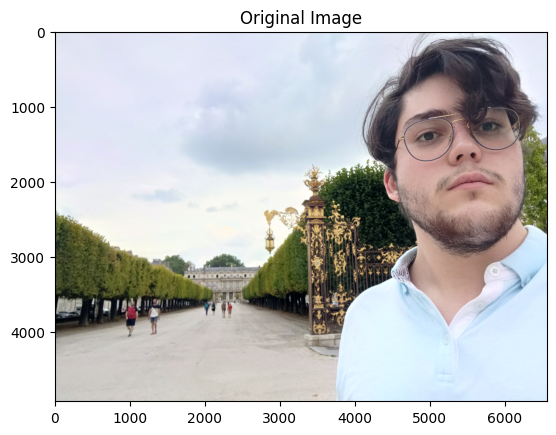

In [ ]:
# Detect persons using Mask R-CNN
print("Detecting persons using Mask R-CNN...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Preprocess the image for the model
transform = transforms.Compose([
    transforms.ToTensor()
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    predictions = model(input_image)[0]

# Extract masks and person class detections
person_masks = []
for i in range(len(predictions["labels"])):
    if predictions["labels"][i] == 1 and predictions["scores"][i] > 0.5:  # Class 1 corresponds to 'person'
        person_masks.append((predictions["masks"][i, 0] > 0.5).cpu().numpy().astype(np.uint8))

if not person_masks:
    print("No persons detected. Exiting...")
    exit()

# Find the person closest to the click
min_dist = float('inf')
closest_mask = None
for mask in person_masks:
    ys, xs = np.where(mask == 1)
    centroid_x, centroid_y = np.mean(xs), np.mean(ys)
    dist = np.sqrt((click_x - centroid_x) ** 2 + (click_y - centroid_y) ** 2)
    if dist < min_dist:
        min_dist = dist
        closest_mask = mask

# Ensure the closest mask is binary and scaled to 255
target_mask = (closest_mask * 255).astype(np.uint8)

# Expand the mask slightly to ensure no artifacts remain
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
target_mask = cv2.dilate(target_mask, kernel, iterations=1)
plt.imshow(target_mask, cmap='gray')
plt.title("Expanded Target Mask")
plt.show()

# Inpainting with Stable Diffusion
print("Performing inpainting using Stable Diffusion...")
# Resize the image and mask to 512x512 (Stable Diffusion requirement)
image_resized = cv2.resize(image, (2048, 2048), interpolation=cv2.INTER_LANCZOS4)
mask_resized = cv2.resize(target_mask, (2048, 2048), interpolation=cv2.INTER_NEAREST)
# Convert resized image and mask to PIL format
image_pil = Image.fromarray(image_resized)
mask_pil = Image.fromarray(mask_resized)

# Perform inpainting
inpainting_result = pipeline(
    prompt="the continuation of the parc",
    image=image_pil,
    mask_image=mask_pil
).images[0]

# Resize the inpainting result back to the original dimensions
inpainting_result_resized = inpainting_result.resize((width, height), Image.LANCZOS)

# Combine the inpainted result with the original image to ensure only masked areas are replaced
inpainting_result_np = np.array(inpainting_result_resized)
final_image = np.where(target_mask[..., None] == 255, inpainting_result_np, image)

# Display the final image
plt.imshow(final_image)
plt.title("Image After Inpainting (Stable Diffusion)")
plt.show()

plt.imshow(image)
plt.title("Original Image")
plt.show()
